# Action-decision networks for visual tracking


## Imports
All the imports are defined here

In [ ]:
%matplotlib inline
import torchvision
from collections import namedtuple
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
from itertools import count
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import time
!pip install pytorch_metric_learning
from pytorch_metric_learning import miners, losses
import cv2
import re
import math
from random import shuffle
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

     |████████████████████████████████| 81kB 2.3MB/s 


ERROR:root:The testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch' 
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


Device: cuda


In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


def bb_intersection_over_union(boxA, boxB, change_format = True):
    if change_format:
      boxA[2] += boxA[0]
      boxA[3] += boxA[1]
      boxB[2] += boxB[0]
      boxB[3] += boxB[1]
      
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:
action_amount = 17
pre_action_amount =10


In [ ]:
#Helper function

transform_tensor = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

def showActions(frame,bbs, true_bb = None):
  if true_bb is not None:
    frame = cv2.rectangle(frame, (true_bb[0], true_bb[1]), (true_bb[0]+true_bb[2], true_bb[1]+true_bb[3]), (0,255,0), 2)    

  for bb in bbs:
    frame = cv2.rectangle(frame, (bb[0], bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), (255,0,0), 2)

 
  imshow(transform_tensor(frame))


### Configuration Class
A simple class to manage configuration

In [ ]:
class Config():
    local_dir = F"../"
    google_dir = F"/content/gdrive/My Drive/"
    dir = google_dir
    model_dir = dir + F"/DTU - Speciale F2020/Action_Decision_Network/Models/"
    training_dir = dir +F"/DTU - Speciale F2020/Action_Decision_Network/Data/Training/"
    validation_dir = dir + F"DTU - Speciale F2020/Action_Decision_Network/Data/Validation/"
    testing_dir = dir + F"DTU - Speciale F2020/Action_Decision_Network/Data/Test"
    train_batch_size = 128
    test_batch_size = 1
    train_number_epochs = 100
    #label_names = tuple(("Left", "Right", "Up", "Down", "Double left", "Double right", "Double up", "Double down", "Scale down", "Scale up", "Stop"))
    label_names = tuple(('Left-Left', 'Double Left-Left', 'Left-Right', 'Double Left-Right', 'Right-Right', 'Double Right-Right', 'Right-Left', 'Double Right-Left', 'Top-Up', 'Double Top-Up', 'Top-Down', 'Double Top-Down', 'Bottom-Down', 'Doube Bottom-Down', 'Bottom-Up', 'Double Bottom-Up', 'Stop'))
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomAffine((0,0), translate=(0.1,0.1), scale =  (1, 1.2)),
                                #transforms.ColorJitter((0.5,2)),
                                #transforms.Resize((275,134)),
                                #transforms.RandomChoice([transforms.RandomCrop((200,100))
                                transforms.ToPILImage(),
                                transforms.Resize((100,50)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                #transforms.RandomErasing(scale=(0.02, 0.2)),
                                ])

### Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class ADNet(nn.Module):
    def __init__(self, m, k):
        super(ADNet, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(0.05),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.05),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.05),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.05),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 50 * 25, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512+m*k, m+2)
        )

        self.softmax = nn.Softmax(-1)
        self.m = m

    def forward(self, x, pre_actions):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        output = torch.cat((output,pre_actions),1)
        output = self.fc2(output)
        
        action = self.softmax(output[:,0:self.m])
        confidence = self.softmax(output[:,self.m:])

        return action, confidence

class ADDuelingNet(nn.Module):
    def __init__(self, m, k):
        super(ADDuelingNet, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),


            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )



        self.fc_v = nn.Sequential(
            nn.Linear(8 * 50 * 25 +m*k, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )      


        self.fc_a = nn.Sequential(
            nn.Linear(8 * 50 * 25 +m*k, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, m)
        )

        self.softmax = nn.Softmax(-1)
        self.m = m

    def forward(self, x, pre_actions):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = torch.cat((output,pre_actions),1)
        v = self.fc_v(output)
        a = self.fc_a(output)
        q = v[:,0:1] + a - a.mean()


        return self.softmax(q), self.softmax(v)

### Enviroment



In [ ]:
class ADenviroment:
    # init method or constructor   
    def __init__(self, dir = None, transform = None, max_notfound = None):
        self.transform = transform  
        self.state = []
        self.count = 0
        self.pre_IoU = 0
        self.files  = []
        self.start_frame_number = 0
        self.frame_number = 0
        self.lines  = []
        self.true_bb  = []
        self.bb = []
        self.frame  = []
        self.pre_frame = []
        self.last_frame = False
        self.done = False
        self.reset(dir)
        pre_action = [-1]*action_amount *pre_action_amount
        pre_action = [float(i) for i in pre_action]
        self.pre_action = torch.tensor([pre_action])
        self.action = -1
        self.action_counter = 0

        if max_notfound is None:
          self.max_notfound = 100
        else:
          self.max_notfound = max_notfound*2

    def getState(self):
        return self.state, 0, self.done #state, reward, done status

    def step(self):
      new_frame = False
      height = self.bb[3]*0.03
      width = self.bb[2]*0.03
      width = width if width >= 1 else 1
      height = height if height >= 1 else 1
      #actions = np.array(([-width, 0, 0, 0],    #left
      #              [width, 0, 0, 0],   #right
      #              [0, -height, 0, 0],   #Up
      #              [0, height, 0, 0],  #Down
      #              [-width*3, 0, 0, 0],  #Double Left
      #              [width*3, 0, 0, 0], #Double Right
      #              [0, -height*3, 0, 0], #Double up
      #              [0, height*3, 0, 0],#Double down
      #              [width/2, height/2,-width, -height], #Scale up # Need to get fixed
      #              [-width/2, -height/2, width, height,], #Scale down # Need to get fixed
      #              [0, 0, 0, 0]),dtype=np.int) #None

      actions = np.array(([-width, 0, width, 0],    #left
                    [-width*3, 0, width*3, 0],    #left
                    [width, 0, -width, 0],   #right
                    [width*3, 0, -width*3, 0],   #right
                    [0, 0, width, 0],    #left
                    [0, 0, width*3, 0],    #left
                    [0, 0, -width, 0],   #right
                    [0, 0, -width*3, 0],   #right
                    [0, -height, 0, height],   #Up
                    [0, -height*3, 0, height*3],   #Up
                    [0, height, 0, -height],   #Up
                    [0, height*3, 0, -height*3],   #Up
                    [0,0, 0, height],   #Up
                    [0, 0, 0, height*3],   #Up
                    [0, 0, 0, -height],   #Up
                    [0, 0, 0, -height*3],   #Up
                    [0, 0, 0, 0]),dtype=np.int) #None


      IoU = np.array([bb_intersection_over_union(self.true_bb.copy(),self.bb.copy() + action) for action in actions])
      if IoU[-1] > 0.9:
         action = len(actions)-1 # stop
         confidence_encoded = np.array([1,0], dtype=np.float32)
         self.pre_IoU = 0
      else:
        if max(IoU) > 0.4:
          if max(IoU) > self.pre_IoU:  
            action = IoU.argmax()
            self.pre_IoU = max(IoU)
          else:
            action = len(actions)-1
            self.pre_IoU = 0
          confidence_encoded = np.array([1,0], dtype=np.float32)
        else:
          action = len(actions)-1 # stop
          confidence_encoded = np.array([0,1], dtype=np.float32)
          self.pre_IoU = 0

      self.bb += actions[action]

      self.bb[self.bb< 1] = 1
      if self.bb[1]+self.bb[3] > self.frame.shape[0]:
        self.bb[1] = self.frame.shape[0]-self.bb[3]
      if self.bb[0]+self.bb[2] > self.frame.shape[1]:
        self.bb[0] = self.frame.shape[1]-self.bb[2]
      pre_state = self.state.clone()
      self.state = self.frame[self.bb[1]:self.bb[1]+self.bb[3],self.bb[0]:self.bb[0]+self.bb[2],:]

      IoU = bb_intersection_over_union(self.true_bb.copy(),self.bb.copy())

      if IoU > 0.9 and action == len(actions)-1:
        if not self.last_frame:
          self.count = 0
          self.frame_number += 2
          line = re.split(r'[;,\s]\s*',self.lines[self.frame_number])
          if len(line) > 4:
            line = line[0:-1]
          self.true_bb = np.array(line,dtype=np.int)
          self.pre_frame = self.frame.copy()
          self.frame = cv2.imread(self.dir+self.files[self.frame_number])
          self.last_frame = len(self.lines) <= self.frame_number+2
          new_frame = True
          self.pre_IoU = 0
        else:
          self.state = None
          self.done = True
      elif self.count >= self.max_notfound or IoU < 0.35 or action == len(actions)-1 or self.action_counter > 30:
        self.count = 0
        if self.last_frame:
          self.state = None

        self.done = True
      else:
        self.count += 1



      if self.transform is not None and self.state is not None:
        self.state = self.transform(self.state).unsqueeze(0)
      
      pre_actions = self.pre_action.clone()
      action_encoded = torch.tensor(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype=np.float32)).unsqueeze(0)
      if self.action != -1:
        self.pre_action[:,action] = 1
      self.pre_action = torch.cat((action_encoded, self.pre_action[:,:-17].float()), 1)
      self.pre_action[:,action] = 1
      action_encoded[:,action] = 1
      self.action = action

      self.action_counter += 1


      return pre_state,  pre_actions , action_encoded, torch.tensor(confidence_encoded).unsqueeze(0), new_frame, self.done#, self.state

    def getRealBB(self):
      return self.true_bb

    def reset(self, directory = None):
      pre_action = [-1]*action_amount *pre_action_amount
      pre_action = [float(i) for i in pre_action]
      self.pre_action = torch.tensor([pre_action])
      self.action = -1
      self.action_counter = 0
      self.pre_IoU = 0


      if directory == None:
        dirs = os.listdir(Config.training_dir)
        while True:
          self.dir = Config.training_dir + dirs[random.randint(0,len(dirs)-1)] +"/"
          if os.path.exists(self.dir + '/groundtruth_rect.txt'):
            break
      else:
        self.dir = Config.training_dir + directory

      #print("New directory:", self.dir)
      self.files = os.listdir(self.dir)
      self.files.sort()
      self.start_frame_number = random.randint(1, int(len(self.files)*0.9)-1)
      self.frame_number = self.start_frame_number

      file = open(self.dir + '/groundtruth_rect.txt')
      self.lines = file.readlines()
      line = re.split(r'[;,\s]\s*',self.lines[self.frame_number-1])
      if len(line) > 4:
        line = line[0:-1]
      self.bb = np.array(line,dtype=np.int)

      line = re.split(r'[;,\s]\s*',self.lines[self.frame_number])
      if len(line) > 4:
        line = line[0:-1]
      self.true_bb = np.array(line,dtype=np.int)
      

      self.frame = cv2.imread(self.dir+self.files[self.frame_number])

      while bb_intersection_over_union(self.bb.copy(),self.true_bb.copy()) > 0.6:
        self.bb[0] += self.bb[2]*random.uniform(-0.1,0.1)
        self.bb[1] += self.bb[3]*random.uniform(-0.1,0.1)
        self.bb[self.bb< 1] = 1
        if self.bb[1]+self.bb[3] > self.frame.shape[0]:
          self.bb[1] = self.frame.shape[0]-self.bb[3]
        if self.bb[0]+self.bb[2] > self.frame.shape[1]:
          self.bb[0] = self.frame.shape[1]-self.bb[2]

      self.pre_frame = self.frame.copy()
      self.state = self.frame[self.bb[1]:self.bb[1]+self.bb[3],self.bb[0]:self.bb[0]+self.bb[2],:]

      if self.transform is not None:
        self.state = self.transform(self.state).unsqueeze(0)
      
      if len(self.files) > 2:
        self.last_frame = False
      else:
        self.last_frame = True

      self.done = False
      self.count = 0


class ADNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset, transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        #self.action_reverse= tuple((1,0,3,2,5,4,7,6,9,8,10))
        self.action_reverse= tuple((2,3,0,1,6,7,4,5, 10,11,8,9,14,15,12,13,16))
        pre_action = [-1]*170
        pre_action = [float(i) for i in pre_action]
        self.pre_action = torch.tensor([pre_action]).squeeze(0)
        
    def __getitem__(self,index):
        img_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        action_encoded = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype=np.float32)
        while os.path.basename(img_tuple[0]).split('.')[1] is 'txt' or not os.path.isfile(os.path.dirname(img_tuple[0]) + '/groundtruth_rect.txt'):
          img_tuple = random.choice(self.imageFolderDataset.imgs)

        img = cv2.imread(img_tuple[0])

        if img.shape[2] == 1:
          img = cv2.merge((img,img,img))
        try:#if os.path.exist(os.path.dirname(img_tuple[0]) + '/groundtruth_rect.txt'):
          file = open(os.path.dirname(img_tuple[0]) + '/groundtruth_rect.txt')
          lines = file.readlines()
          line = re.split(r'[;,\s]\s*',lines[int(os.path.splitext(os.path.basename(img_tuple[0]))[0])-1])
          if len(line) > 4:
            line = line[0:-1]
          bb = np.array(line,dtype=np.int)
          New = False
        except:#else:
          #return
          New = True
          file_gt = open(os.path.dirname(img_tuple[0]) + '/gt.txt')
          file = open(os.path.dirname(img_tuple[0]) + '/det.txt')
          lines_gt = file_gt.readlines()
          lines = file.readlines()
          img_number = int(os.path.splitext(os.path.basename(img_tuple[0]))[0])
          
          lines_temp = []
          for l in lines:
            line = re.split(r'[;,\s]\s*', l)
            if int(line[0]) == img_number:
              lines_temp.append(line) 
        
          shuffle(lines_temp)
          IoU = [0]
          while max(IoU) < 0.7:
            line = re.split(r'[;,\s]\s*', lines[random.randint(0,len(lines)-1)])
            IoU = [0]
            for l in lines_gt:
                line_gt = re.split(r'[;,\s]\s*', l)
                if line[0] == line_gt[0]:
                    IoU.append(bb_intersection_over_union([int(float(line[2])), int(float(line[3])), int(float(line[4])), int(float(line[5]))], [int(float(line_gt[2])), int(float(line_gt[3])), int(float(line_gt[4])), int(float(line_gt[5]))]))

          bb = np.array(line[2:6],dtype=np.float).astype(int)


        
        #img_crop_true = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2],:]
        height =bb[3]*0.03
        width =bb[2]*0.03
        width = width if width >= 1 else 1
        height = height if height >= 1 else 1
        #actions = np.array(([-width, 0, 0, 0],    #left
        #                    [width, 0, 0, 0],   #right
        #                    [0, -height, 0, 0],   #Up
        #                    [0, height, 0, 0],  #Down
        #                    [-width*3, 0, 0, 0],  #Double Left
        #                    [width*3, 0, 0, 0], #Double Right
        #                    [0, -height*3, 0, 0], #Double up
        #                    [0, height*3, 0, 0],#Double down
        #                    [width/2, height/2,-width, -height], #Scale down # Need to get fixed
        #                    [-width/2, -height/2, width, height,], #Scale up # Need to get fixed
        #                    [0, 0, 0, 0]),dtype=np.int) #None

        actions = np.array(([-width, 0, width, 0],    #left
                            [-width*3, 0, width*3, 0],    #left
                            [width, 0, -width, 0],   #right
                            [width*3, 0, -width*3, 0],   #right
                            [0, 0, width, 0],    #left
                            [0, 0, width*3, 0],    #left
                            [0, 0, -width, 0],   #right
                            [0, 0, -width*3, 0],   #right
                            [0, -height, 0, height],   #Up
                            [0, -height*3, 0, height*3],   #Up
                            [0, height, 0, -height],   #Up
                            [0, height*3, 0, -height*3],   #Up
                            [0,0, 0, height],   #Up
                            [0, 0, 0, height*3],   #Up
                            [0, 0, 0, -height],   #Up
                            [0, 0, 0, -height*3],   #Up
                            [0, 0, 0, 0]),dtype=np.int) #None


        #img_crop_true = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2],:]

        #Sample fake patch
        sample = random.uniform(0,1)
        
        if sample < 0.6 and not New:
          bb_fake = bb.copy()
          if sample < 0.1:
            bb_fake[0] += bb[2]*random.uniform(-10,10)
            bb_fake[1] += bb[3]*random.uniform(-10,10)
            bb_fake[2] += bb[2]*random.uniform(0,10)
            bb_fake[3] += bb[3]*random.uniform(0,10)
            bb_fake[bb_fake< 1] = 1
            if bb_fake[1]+bb_fake[3] > img.shape[0]:
              bb_fake[1] = img.shape[0]-bb_fake[3]
            if bb_fake[0]+bb_fake[2] > img.shape[1]:
              bb_fake[0] = img.shape[1]-bb_fake[2]
          else:
            while bb_intersection_over_union(bb.copy(),bb_fake.copy()) > 0.1:
              bb_fake[0] += bb[2]*random.uniform(-0.1,0.1)
              bb_fake[1] += bb[3]*random.uniform(-0.1,0.1)
              bb_fake[bb_fake< 1] = 1
              if bb_fake[1]+bb_fake[3] > img.shape[0]:
                bb_fake[1] = img.shape[0]-bb_fake[3]
              if bb_fake[0]+bb_fake[2] > img.shape[1]:
                bb_fake[0] = img.shape[1]-bb_fake[2]
          
          IoU = np.array([bb_intersection_over_union(bb.copy(),bb_fake.copy() + action) for action in actions])
          if max(IoU) > 0.7:
              label = IoU.argmax()
              confidence_encoded = np.array([1,0], dtype=np.float32)
          elif max(IoU) > 0.4:
            label = IoU.argmax()
            confidence_encoded = np.array([0,1], dtype=np.float32)
          else:
            label = len(actions)-1 # stop
            confidence_encoded = np.array([0,1], dtype=np.float32)
          bb = bb_fake

        else:
          label = random.randint(0, len(actions)-1) # get action      
          bb += actions[label]
          label = self.action_reverse[label]
          bb[bb< 1] =  0
          if bb[1]+bb[3] > img.shape[0]:
            bb[1] = img.shape[0]-bb[3]
          if bb[0]+bb[2] > img.shape[1]:
            bb[0] = img.shape[1]-bb[2]

          confidence_encoded = np.array([1,0], dtype=np.float32)

        img_crop = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2],:]
        action_encoded[label] = 1

        bb_next = bb + actions[label]
        #img_crop_next = img[bb_next[1]:bb_next[1]+bb_next[3],bb_next[0]:bb_next[0]+bb_next[2],:]


        #print("Before", img_crop.shape)
        #print("Action", label)
        #print("After", img_crop_next.shape)
        if self.transform is not None:
          img_crop = self.transform(img_crop)
          #img_crop_next = self.transform(img_crop_next)

        return img_crop, self.pre_action, action_encoded, confidence_encoded#img_crop_next
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


587 1129 20
Real: [147  86  51 124]
Current: [149  86  46 124]


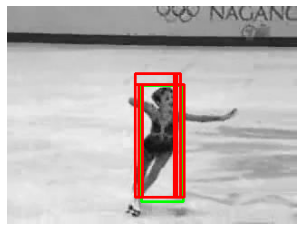

8
Real: [149  79  50 133]
Current: [149  86  46 124]


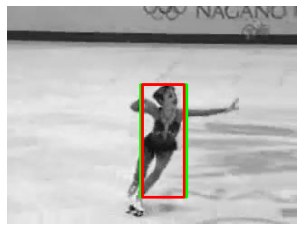

1


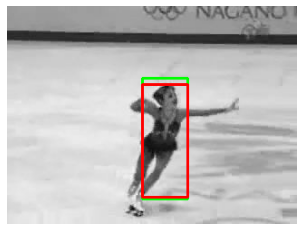

In [ ]:
# Enviroment test
env = ADenviroment(None, Config.transform, pre_action_amount)
print(env.frame_number, len(env.files), env.max_notfound)
#net.eval()
state, reward, done = env.getState()
bb = [env.bb.copy()]
pre_action = [0]*action_amount *pre_action_amount
pre_action = [float(i) for i in pre_action]
pre_action = torch.tensor([pre_action]).cuda()

env.reset()#"Human2/")

bb = []
counter = 0
for i in range(10):
  #print(i)
  #action = random.randint(0,1)
  #action, confidence = policy_net(state.cuda(), pre_action.cuda())
  #print("Action:", Config.label_names[action.max(1)[1].view(1,1).item()],action.max(1)[1].view(1,1).item(), "\tConfidence:", confidence[0,0].item())
  true_bb = env.getRealBB().copy()
  state, pre_actions, action_encoded, confidence, new_frame, done = env.step()#action.max(1)[1].view(1,1))
  bb.append(env.bb.copy())
  draw = True
  counter += 1

  #imshow(torchvision.utils.make_grid(torch.cat((state,next_state), 0)))
  if new_frame and draw:
    print("Real:", env.getRealBB())
    print("Current:", env.bb)
    showActions(env.pre_frame.copy(),bb, true_bb)

    bb = []
    draw = False
    print(counter)
    counter = 0

  if done:
    env.reset()
    bb = []

  if state is None:
    break



#Draw fianl
if draw:
  showActions(env.pre_frame.copy(),bb, env.getRealBB().copy())
  bb = []
  draw = False


In [ ]:
folder_dataset_train = dset.ImageFolder(root=Config.training_dir)
transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomAffine((0,0), translate=(0.1,0.1), scale =  (1, 1.2)),
                                #transforms.ColorJitter((0.5,2)),
                                #transforms.Resize((275,134)),
                                #transforms.RandomChoice([transforms.RandomCrop((200,100))
                                transforms.ToPILImage(),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((100,50)),
                                transforms.ToTensor(),
                                ##transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                #transforms.RandomErasing(scale=(0.02, 0.2)),
                                ])

siamese_dataset_train = ADNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transform,
                                        should_invert=False)

vis_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=Config.train_batch_size)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)


for i in range(64):

  #imshow(torchvision.utils.make_grid(example_batch[3][i].unsqueeze(0)))
  print(example_batch[0][i].shape)
  imshow(torchvision.utils.make_grid(torch.cat(  (example_batch[0][i].unsqueeze(0), example_batch[0][i].unsqueeze(0)  )     )))
  #imshow(torchvision.utils.make_grid(example_batch[4][i].unsqueeze(0)))
  print("Action:", Config.label_names[np.where(example_batch[2][i].numpy()==1)[0][0]])
  print("Action:", np.where(example_batch[2][i].numpy()==1)[0])
  print("Confidence:", example_batch[3][i][0].numpy() == 1)
  print("Pre_action:", example_batch[1][i])


### Replay memory

In [1]:
Transition = namedtuple('Transition',('state', 'pre_action', 'action_encoded', 'confidence'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(*args))
        else:
          del self.memory[self.position] 
          self.memory.insert(self.position, Transition(*args))
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

def sample_memory(memory, device, non_blocking=False):
    # sample replay buffer
    transitions = memory.sample(BATCH_SIZE)
    try:
      batch = Transition(*zip(*transitions))
    except:
      print("Object not iterable")
      return None

    # convert to tensors and create batches
    state_batch = torch.cat(batch.state)
    action_encoded_batch = torch.cat(batch.action_encoded)
    pre_action_batch = torch.cat(batch.pre_action)
    confidence_batch = torch.cat(batch.confidence)



    return state_batch, pre_action_batch, action_encoded_batch, confidence_batch

NameError: ignored

## Supervised Learning Training Time!








In [ ]:
# Trainin parameters
BATCH_SIZE = Config.train_batch_size
GAMMA = 0.99
EPS_START = 0.2
EPS_END = 0.1
MEMORY_SIZE = 100000
EPS_DECAY = 50000
TARGET_UPDATE = 128 
START_OPTIMIZER = 256
OPTIMIZE_FREQUENCE = 128
learning_rate = 10e-6
action_amount = 17
pre_action_amount = 10

net = ADNet(action_amount,pre_action_amount).cuda()
#net.load_state_dict(torch.load(Config.model_dir+"ADNet_SL_Advanced_Mar_30_2020_0809.pt"))

net.train()

folder_dataset_train = dset.ImageFolder(root=Config.training_dir)
siamese_dataset_train = ADNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=Config.transform,
                                        should_invert=False)
dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=Config.train_batch_size,
                        batch_size=BATCH_SIZE)
dataiter = iter(dataloader)


env = ADenviroment(None, Config.transform, pre_action_amount)
print("Enviroment start frame:", env.start_frame_number, " - Total frame:", len(env.files), " - Enviroment max not found:", env.max_notfound)

optimizer = optim.AdamW(net.parameters(), lr=learning_rate)
#optimizer = optim.SGD(policy_net.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

criterion = nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

memory = ReplayMemory(MEMORY_SIZE)
#memory = PER(MEMORY_SIZE, GAMMA)

timestamp = time.strftime('%b_%d_%Y_%H%M', time.localtime())
if not 'BACKUP_NAME' in locals():
  BACKUP_NAME = "ADNet_SL_Advanced_" + timestamp + ".pt"
path = Config.model_dir + BACKUP_NAME
#torch.save(policy_net.state_dict(), path)
print(path)

steps_done = 0
i_episode = 0
num_episodes = 100000
counter = []
loss_history = []
counter_hard = []
loss_hard_history = []
accruacy_history = []
iteration_number= 0



Enviroment start frame: 1343  - Total frame: 1699  - Enviroment max not found: 20
/content/gdrive/My Drive//DTU - Speciale F2020/Action_Decision_Network/Models/ADNet_SL_Advanced_May_19_2020_1046.pt


**Run training**


Epoch number: 0	 Current loss: 0.76479	 Current accruacy: 63.671875% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 0	 Current loss: 0.73465	 Current accruacy: 62.890625% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 0	 Current loss: 0.69478	 Current accruacy: 65.625% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 0	 Current loss: 0.66214	 Current accruacy: 64.0625% Type: Dataloader torch.Size([128, 3, 100, 50])
Model Saved 0


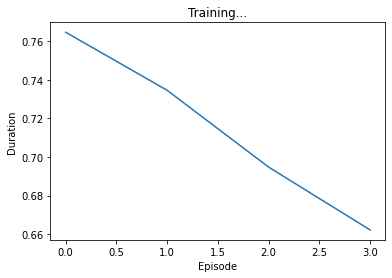

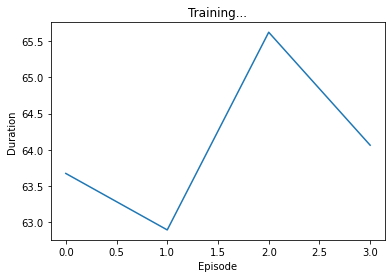

Epoch number: 1	 Current loss: 0.68694	 Current accruacy: 62.5% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 1	 Current loss: 0.57419	 Current accruacy: 72.265625% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 1	 Current loss: 0.59389	 Current accruacy: 68.75% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 1	 Current loss: 0.48818	 Current accruacy: 74.609375% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 2	 Current loss: 0.50402	 Current accruacy: 75.78125% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 2	 Current loss: 0.52407	 Current accruacy: 72.265625% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 2	 Current loss: 0.49368	 Current accruacy: 74.609375% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 2	 Current loss: 0.46095	 Current accruacy: 75.390625% Type: Dataloader torch.Size([128, 3, 100, 50])
Epoch number: 3	 Current loss: 0.4295	 Current accruacy: 79.6875% Type: Dataloader

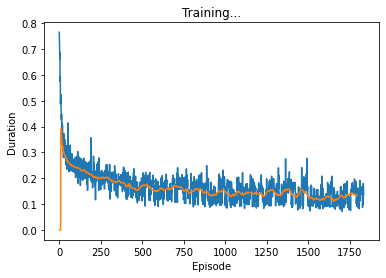

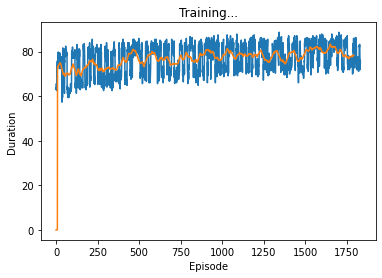

Epoch number: 501	 Current loss: 0.15558	 Current accruacy: 71.875% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 501	 Current loss: 0.15719	 Current accruacy: 73.046875% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 501	 Current loss: 0.18046	 Current accruacy: 74.21875% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 501	 Current loss: 0.14135	 Current accruacy: 75.78125% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 502	 Current loss: 0.15935	 Current accruacy: 75.78125% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 502	 Current loss: 0.15011	 Current accruacy: 75.0% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 502	 Current loss: 0.15887	 Current accruacy: 70.703125% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 502	 Current loss: 0.15747	 Current accruacy: 77.734375% Type: Memory torch.Size([128, 3, 100, 50])
Epoch number: 503	 Current loss: 0.17946	 Current accruacy: 68.75% Type: Memory torch.Size([128, 3,

KeyboardInterrupt: ignored

In [ ]:
batch_flag = False

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()#"Human2/")

    for t in count():
        # Select and perform an action


        state, pre_actions, action_encoded, confidence, new_frame, done = env.step()#action.max(1)[1].view(1,1))


        # Store the transition in memory
        memory.push(state, pre_actions, action_encoded, confidence)
        #memory.push(state, action.cpu(), pre_action.cpu(), reward,  next_state, done, policy_net, target_net)

        if batch_flag and steps_done > START_OPTIMIZER:
          batch = sample_memory(memory, device)
        else:
          batch = (torch.tensor([-1]),1)
          while batch[0].shape[0] == 1:
            batch = next(dataiter, None)
            if batch is None:
              dataiter = iter(dataloader)
              batch = next(dataiter,None)

        batch_flag = not batch_flag

        state, pre_actions, action_true, confidence_true = batch
        state, pre_actions, action_true, confidence_true = state.cuda(), pre_actions.cuda(), action_true.cuda(), confidence_true.cuda() 

        optimizer.zero_grad()
        #print(state.shape, pre_actions.shape, action_true.shape, confidence_true.shape)
        #print(state, pre_actions)
        action, confidence = net(state, pre_actions)

        #loss = criterion(action, action_true) + criterion(confidence, confidence_true)
        action = action*confidence_true[:,:1]
        action_true = action_true*confidence_true[:,:1]
        loss = criterion(action, action_true) + criterion(confidence, confidence_true)
        loss.backward(retain_graph=True)
        optimizer.step()

        if t %10 == 0:
          action_true_max = action_true.argmax(1).long()
          action_max = action.argmax(1).long()
          confidence_true_max = confidence_true.argmax(1).long()
          confidence_max = confidence.argmax(1).long()
          accruacy_history.append(50*(float(sum(action_max == action_true_max))/len(action_max)+float(sum(confidence_max == confidence_true_max))/len(confidence_max)))
          print("Epoch number: {}\t Current loss: {}\t Current accruacy: {}%".format(i_episode,round(loss.item(),5), accruacy_history[-1]), "Type:", "Memory" if not batch_flag and steps_done > START_OPTIMIZER else "Dataloader", state.shape )
          iteration_number +=10
          #counter.append(iteration_number)
          loss_history.append(loss.item())

          # Clean up
          del state, pre_actions, action_true, confidence_true
          torch.cuda.empty_cache()

        steps_done += 1

        if done:
          break



    # Print status parameters
    # Save model
    if i_episode % 100 == 0:
      torch.save(net.state_dict(), path)
      print("Model Saved %d" %(i_episode))

    if i_episode % 500 == 0:
      # Plot learning curves
      plt.figure()
      durations_t = torch.tensor(loss_history, dtype=torch.float)
      plt.title('Training...')
      plt.xlabel('Episode')
      plt.ylabel('Duration')
      plt.plot(durations_t.numpy())
      # Take 100 episode averages and plot them too
      if len(durations_t) >= 50:
          means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
          means = torch.cat((torch.zeros(9), means))
          plt.plot(means.numpy())

      plt.figure()
      durations_t = torch.tensor(accruacy_history, dtype=torch.float)
      plt.title('Training...')
      plt.xlabel('Episode')
      plt.ylabel('Duration')
      plt.plot(durations_t.numpy())
      # Take 100 episode averages and plot them too
      if len(durations_t) >= 50:
          means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
          means = torch.cat((torch.zeros(9), means))
          plt.plot(means.numpy())
      plt.show()

    
    # Clear used cuda memory
    torch.cuda.empty_cache()


print('Complete')
plt.show()

## Show results



In [ ]:
def test_network(env, n_episodes, net):
    episode_test_totalRewards =[]
    episode_test_durations = []
    for episode in range(n_episodes):
      env.reset()
      pre_action = [0]*action_amount *pre_action_amount
      pre_action = [float(i) for i in pre_action]
      pre_action = torch.tensor([pre_action]).cuda()
      state, reward, done = env.getState()
      total_reward = 0.0
      for t in count():
          state_cuda = state.to(device)
          action, confidence = net(state_cuda, pre_action)
          action = action.max(1)[1].view(1,1)
          pre_action = torch.cat((action.float(), pre_action[:,:-1].float()), 1)
          state, reward, new_frame, done = env.step(action.item())
          total_reward += reward
          
          if done or t > 12000:
              episode_test_durations.append(t + 1)
              episode_test_totalRewards.append(total_reward)
              break
          del state_cuda
          del action
          del confidence
    mean = np.mean(episode_test_totalRewards)
    var = np.var(episode_test_totalRewards)
    del pre_action
    torch.cuda.empty_cache()
    return mean, var

env_test = ADenviroment(None,  transform)
mean, var = test_network(env_test, 1, net)
print("Mean:", mean, " - Variance:", var)

TypeError: ignored

In [ ]:
# Plot learning curves
plt.figure(2)
plt.clf()
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())

plt.figure(3)
rewards_t = torch.tensor(episode_totalRewards, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.plot(rewards_t.numpy())
if len(durations_t) >= 50:
    means = rewards_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())


NameError: ignored

<Figure size 432x288 with 0 Axes>

## Policy gradient learning


In [ ]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [ ]:
# training settings

num_episodes = 1000000
rollout_limit = 500 # max rollout length
discount_factor = 0.80 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency
action_encoded = torch.tensor(np.zeros((n_actions), dtype = np.int)).unsqueeze(0).float()
steps_done = 0
# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        pre_action = [0]*action_amount *pre_action_amount
        pre_action = [float(i) for i in pre_action]
        pre_action = torch.tensor([pre_action])
        total_reward = 0
        new_frame_count = 0
        actions = np.zeros((n_actions), dtype = np.int)

        s, r, done = env.getState()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            a, threshold = select_action(s.cuda(), pre_action.cuda(), policy_net)
            s1, r, new_frame, done= env.step(a)
            rollout.append((s.numpy(), a.cpu(), r, pre_action.detach().numpy()))
            pre_action = torch.cat((action_encoded, pre_action[:,:-n_actions].float()), 1)
            pre_action[:,a.item()] = 1
            s = s1
            total_reward += r
            new_frame_count += int(new_frame)
            actions[a] += 1
            steps_done += 1
            if done: break

        print("Episode number:", i, " - Total reward:", round(total_reward,2), "\t  - Frames:", new_frame_count, " - Threshold:", round(threshold,2), " - Actions: ", actions, "- Steps:", steps_done)


        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        pre_action = np.vstack(rollout[:,3])
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        a_probs, _ = policy_net(torch.from_numpy(states).float().cuda(), torch.from_numpy(pre_action).float().cuda())
        a_probs = a_probs.gather(1, torch.from_numpy(actions).cuda()).view(-1)
        loss = -torch.mean(torch.mul(torch.log(a_probs), torch.from_numpy(returns).float().cuda()))

        # optimize
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(policy_net.parameters(), 10.)
        optimizer.step()

        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                s, r, done = env.getState()
                pre_action = [0]*action_amount *pre_action_amount
                pre_action = [float(i) for i in pre_action]
                pre_action = torch.tensor([pre_action], requires_grad=True)
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a, _ = policy_net(torch.from_numpy(np.atleast_2d(s)).float().cuda(), pre_action.cuda())
                    a =  a.argmax().item()
                    s, r, _, done = env.step(a)
                    reward += r
                    pre_action = torch.cat((action_encoded, pre_action[:,:-n_actions].float()), 1)
                    pre_action[:,a] = 1
                    if done: break
                validation_rewards.append(reward)
            print('TEST: {:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    